#    t-SNE Visiulization of Amazon Fine Food Reviews


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## 1.  Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\SG\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# 2. Exploratory Data Analysis

## 2.1 Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

##  2.2 Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [10]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [11]:
#code to clean punctuation, html tags.
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'ourselves', 'as', 'hasn', 'do', 'once', 'my', "she's", 'about', 'will', 'who', 'before', 'why', 'too', "should've", 'most', 'haven', 'ain', 'himself', 'a', 'under', 'she', 'or', 'out', 'same', 'have', "won't", 'd', 'her', 'all', 'where', "don't", "doesn't", 'again', 'here', 'those', 'other', 'was', 'doing', 'below', 'yourselves', 'be', "weren't", "shouldn't", 'herself', 'this', 'some', 'he', "couldn't", 'weren', 'we', 'yourself', 'by', 'while', 'not', 'only', "you'd", 'off', 'were', "haven't", 'an', 'when', "wouldn't", 'has', 're', 'to', 'in', 'being', 'hadn', 'up', 'what', 'of', 'than', 'your', 'didn', 'doesn', "you'll", 'down', "wasn't", 'own', 'don', 'couldn', 'is', 'their', 'few', 'there', 'more', 'no', 'they', 'his', 'ours', 'with', 'just', "shan't", 'am', 'are', "mightn't", 'after', 'from', "hasn't", 'the', 'it', 'wouldn', 'but', 'which', "aren't", 'themselves', "isn't", 'aren', 'ma', 'very', 'y', 'isn', 'm', 'so', 'shouldn', 'further', 'any', 'on', 'wasn', 'through', 'then', "

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [13]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [14]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [15]:
#I have RAM of only 4GB hence performing with 2K reviews only.
final_new=final.sample(2000)

In [16]:
#Displaying first 2 rows cleaned data.
final_new.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
76006,82712,B003KLSXE6,ATYTDC2SH1GX9,Paula A. Moscariello,0,0,negative,1346112000,very unhappy,These cracker seem to be on the healthy side b...,cracker seem healthi side hard rock buy
185531,201243,B0038BDVNQ,A1XKHI5HSFXEIW,"Swan Lake ""Odile""",1,1,positive,1326153600,I love it,Great product. I gifted to my boss for Christm...,great product gift boss christma green neon co...


In [17]:
final_new.shape

(2000, 11)

In [18]:
score_new=final_new['Score']

In [19]:
score_new.shape

(2000,)

In [20]:
score_new.value_counts()

positive    1679
negative     321
Name: Score, dtype: int64

# 3. Bag of Words (BoW)

In [21]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final_new['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (2000, 6250)
the number of unique words  6250


In [22]:
#Performing Data Standardization.
from sklearn.preprocessing import StandardScaler

final_data = StandardScaler(with_mean = False).fit_transform(final_counts)
final_data.shape

C:\Users\SG\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\SG\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(2000, 6250)

In [23]:
type(final_data)

scipy.sparse.csr.csr_matrix

In [24]:
#converting datapoints sparse to dense as our tsne takes only dense data.
final_data = final_data.toarray()

In [25]:
final_counts.shape

(2000, 6250)

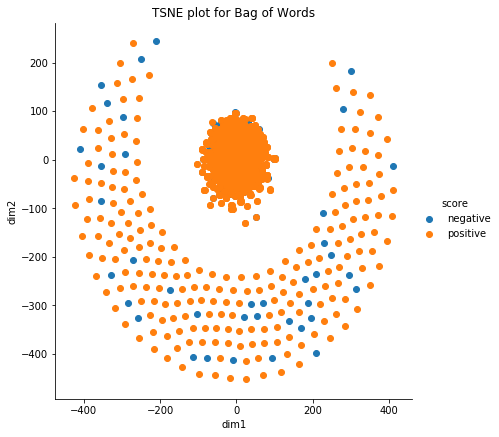

In [26]:
#t-SNE PLOT for BOW

#importing mainfold for visiulization plot from tsne
from sklearn.manifold import TSNE

#fitting our model with data
model = TSNE(n_components=2, random_state=0, perplexity = 2, n_iter = 5000)
tsne_data = model.fit_transform(final_data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_new)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", height=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE plot for Bag of Words")
plt.show()

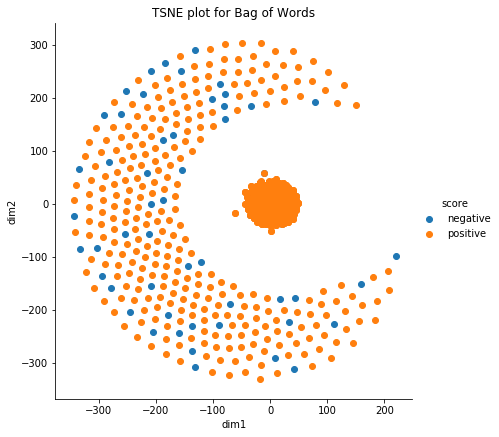

In [27]:

#importing mainfold for visiulization plot from tsne
from sklearn.manifold import TSNE

#fitting our model with data
model = TSNE(n_components=2, random_state=0, perplexity = 5, n_iter = 5000)
tsne_data = model.fit_transform(final_data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_new)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", height=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE plot for Bag of Words")
plt.show()

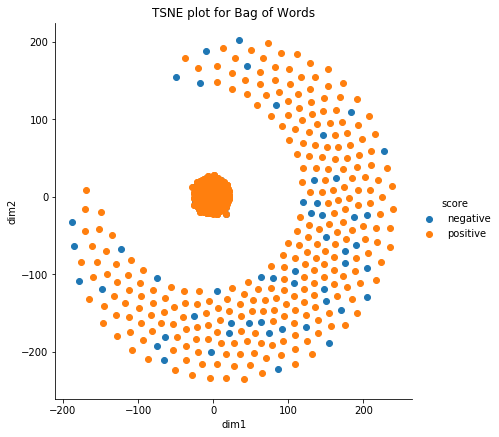

In [28]:

#importing mainfold for visiulization plot from tsne
from sklearn.manifold import TSNE

#fitting our model with data
model = TSNE(n_components=2, random_state=0, perplexity = 30, n_iter = 5000)
tsne_data = model.fit_transform(final_data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_new)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", height=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE plot for Bag of Words")
plt.show()

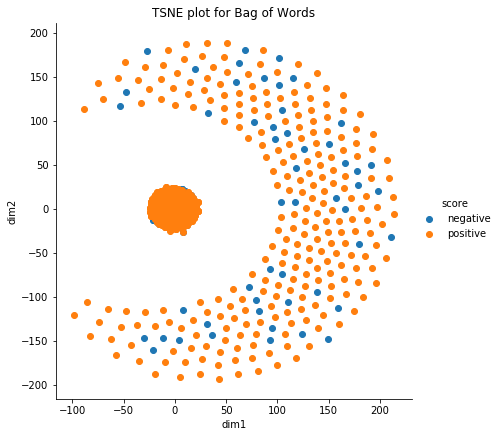

In [29]:

#importing mainfold for visiulization plot from tsne
from sklearn.manifold import TSNE

#fitting our model with data
model = TSNE(n_components=2, random_state=0, perplexity = 50, n_iter = 5000)
tsne_data = model.fit_transform(final_data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_new)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", height=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE plot for Bag of Words")
plt.show()

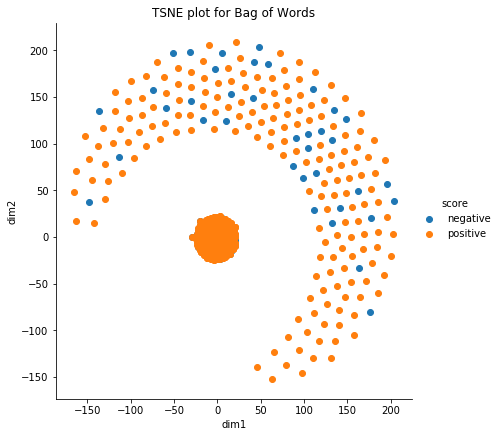

In [30]:

#importing mainfold for visiulization plot from tsne
from sklearn.manifold import TSNE

#fitting our model with data
model = TSNE(n_components=2, random_state=0, perplexity = 100, n_iter = 5000)
tsne_data = model.fit_transform(final_data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_new)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", height=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE plot for Bag of Words")
plt.show()

**Observation:-**
    From tsne plot we can say that it is overlapping with each other. So, we cant seperate positive and negative points from each other by drawing a line.

# 4. TF-IDF

In [31]:
#Tf_idf
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final_new['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (2000, 64012)
the number of unique words including both unigrams and bigrams  64012


In [32]:
#Performing Data Standardization.
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean = False)
final_data = std.fit_transform(final_tf_idf)

In [33]:
#converting datapoints sparse to dense as our tsne takes only dense data.
final_data = final_data.toarray()

In [34]:
final_data.shape

(2000, 64012)

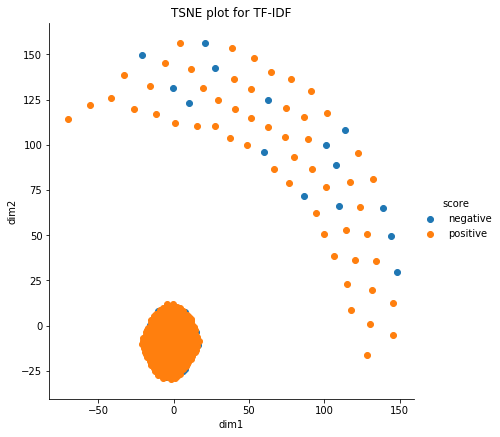

In [35]:
#importing mainfold for visiulization plot from tsne
from sklearn.manifold import TSNE

#fitting our model with data
model = TSNE(n_components=2, random_state=0, perplexity = 2, n_iter = 5000)
tsne_data = model.fit_transform(final_data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_new)).T
tsne_df = pd.DataFrame(data = tsne_data, columns = ("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue = "score", height = 6).map(plt.scatter, "dim1", "dim2").add_legend()
plt.title("TSNE plot for TF-IDF")
plt.show()

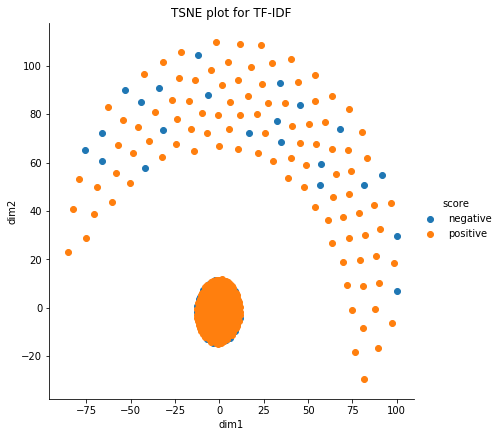

In [36]:
#importing mainfold for visiulization plot from tsne
from sklearn.manifold import TSNE

#fitting our model with data
model = TSNE(n_components=2, random_state=0, perplexity = 5, n_iter = 5000)
tsne_data = model.fit_transform(final_data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_new)).T
tsne_df = pd.DataFrame(data = tsne_data, columns = ("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue = "score", height = 6).map(plt.scatter, "dim1", "dim2").add_legend()
plt.title("TSNE plot for TF-IDF")
plt.show()

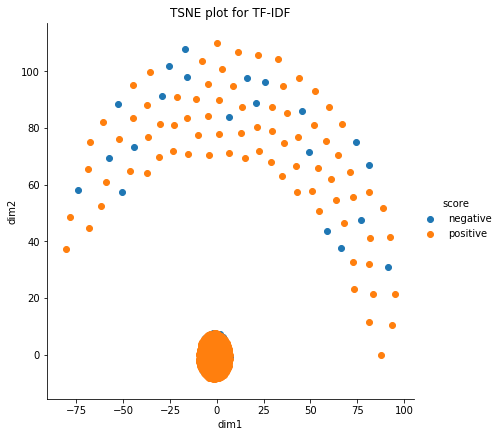

In [37]:
#importing mainfold for visiulization plot from tsne
from sklearn.manifold import TSNE

#fitting our model with data
model = TSNE(n_components=2, random_state=0, perplexity = 30, n_iter = 5000)
tsne_data = model.fit_transform(final_data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_new)).T
tsne_df = pd.DataFrame(data = tsne_data, columns = ("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue = "score", height = 6).map(plt.scatter, "dim1", "dim2").add_legend()
plt.title("TSNE plot for TF-IDF")
plt.show()

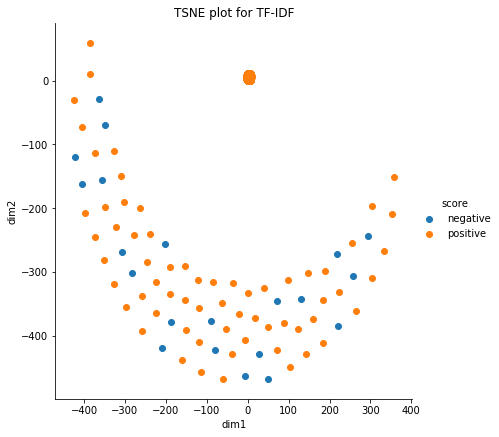

In [38]:
#importing mainfold for visiulization plot from tsne
from sklearn.manifold import TSNE

#fitting our model with data
model = TSNE(n_components=2, random_state=0, perplexity = 50, n_iter = 5000)
tsne_data = model.fit_transform(final_data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_new)).T
tsne_df = pd.DataFrame(data = tsne_data, columns = ("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue = "score", height = 6).map(plt.scatter, "dim1", "dim2").add_legend()
plt.title("TSNE plot for TF-IDF")
plt.show()

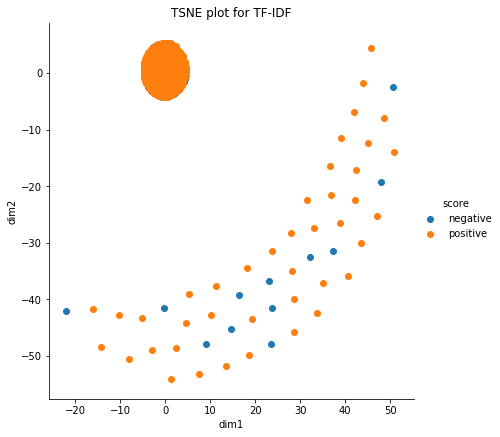

In [39]:
#importing mainfold for visiulization plot from tsne
from sklearn.manifold import TSNE

#fitting our model with data
model = TSNE(n_components=2, random_state=0, perplexity = 100, n_iter = 5000)
tsne_data = model.fit_transform(final_data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_new)).T
tsne_df = pd.DataFrame(data = tsne_data, columns = ("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue = "score", height = 6).map(plt.scatter, "dim1", "dim2").add_legend()
plt.title("TSNE plot for TF-IDF")
plt.show()

**Observations:-**
    This plot is also looked like Bag of Words i.e. overlapped. Hence, cant seperate positive and negative points from each other.

# 5. Word2Vec

In [40]:
# Train your own Word2Vec model using your own text corpus
import gensim
list_of_sent = []
for sent in final_new['Text'].values:
    filtered_sentence = []
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [41]:
print(final_new['Text'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

These cracker seem to be on the healthy side but their hard as a rock, will not be buying them again.
*****************************************************************
['these', 'cracker', 'seem', 'to', 'be', 'on', 'the', 'healthy', 'side', 'but', 'their', 'hard', 'as', 'a', 'rock', 'will', 'not', 'be', 'buying', 'them', 'again']


In [42]:
import gensim
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [43]:
w2v = w2v_model[w2v_model.wv.vocab]
w2v.shape

(2498, 50)

In [44]:
words = list(w2v_model.wv.vocab)

In [45]:
print(len(words))

2498


# 5.1 Avg-W2V

In [46]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

2000
50


In [47]:
#Performing Data Standardization.
from sklearn.preprocessing import StandardScaler
final_data = StandardScaler().fit_transform(sent_vectors)
print(final_data.shape)

(2000, 50)


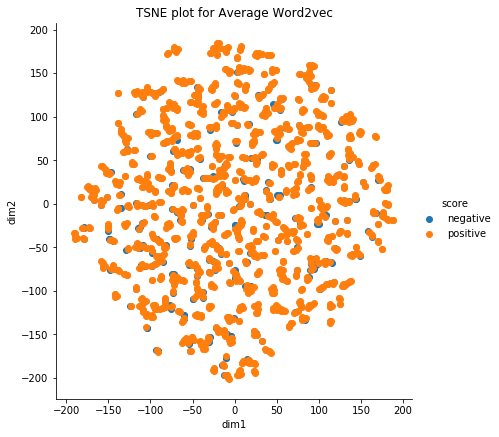

In [48]:
#importing mainfold for visiulization plot from tsne
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 2, n_iter = 5000)

#fitting our model with data
tsne_data = model.fit_transform(final_data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_new)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", height=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE plot for Average Word2vec")
plt.show()

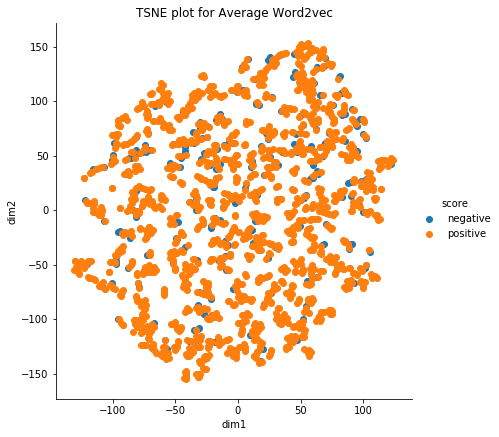

In [49]:
#importing mainfold for visiulization plot from tsne
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 5, n_iter = 5000)

#fitting our model with data
tsne_data = model.fit_transform(final_data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_new)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", height=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE plot for Average Word2vec")
plt.show()

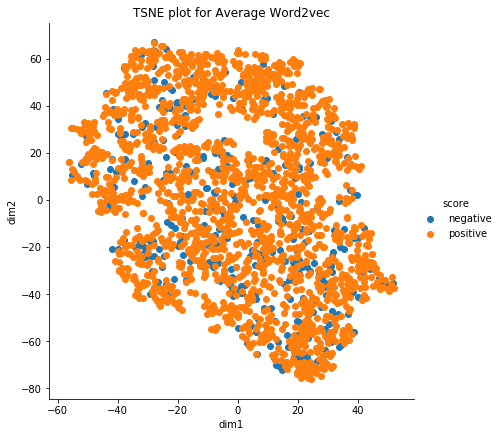

In [50]:
#importing mainfold for visiulization plot from tsne
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 30, n_iter = 5000)

#fitting our model with data
tsne_data = model.fit_transform(final_data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_new)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", height=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE plot for Average Word2vec")
plt.show()

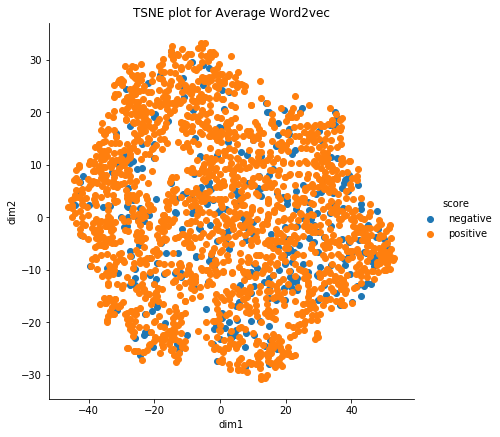

In [51]:
#importing mainfold for visiulization plot from tsne
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 50, n_iter = 5000)

#fitting our model with data
tsne_data = model.fit_transform(final_data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_new)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", height=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE plot for Average Word2vec")
plt.show()

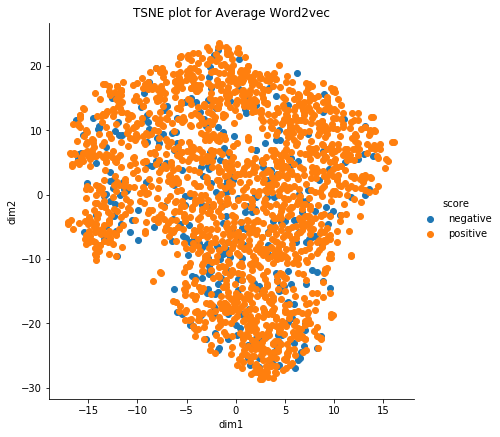

In [52]:
#importing mainfold for visiulization plot from tsne
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 100, n_iter = 5000)

#fitting our model with data
tsne_data = model.fit_transform(final_data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_new)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", height=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE plot for Average Word2vec")
plt.show()

**Observations:-** 
This plot also looked messy and overlapped like bow and tf-idf. Cant seperate positive and negative reviews.

# 5.2 TFIDF-Word2Vec

In [53]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final_new['CleanedText'].values)
tf_idf_matrix.shape

(2000, 6250)

In [54]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1


In [55]:
#checking null values
len(tfidf_sent_vectors)
np.isnan(tfidf_sent_vectors)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [56]:
# To replace nan with 0 and inf with large finite number
tfidf_sent_vectors = np.nan_to_num(tfidf_sent_vectors)

In [57]:
#Performing data Standardization.
from sklearn.preprocessing import StandardScaler
final_data = StandardScaler().fit_transform(sent_vectors)
print(final_data.shape)

(2000, 50)


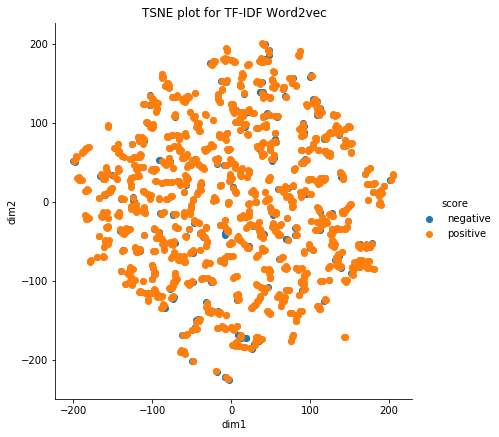

In [58]:
#importing mainfold for visiulization plot from tsne
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 2, n_iter = 5000)

#fitting our model with data
tsne_data = model.fit_transform(tfidf_sent_vectors)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_new)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", height=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE plot for TF-IDF Word2vec")
plt.show()

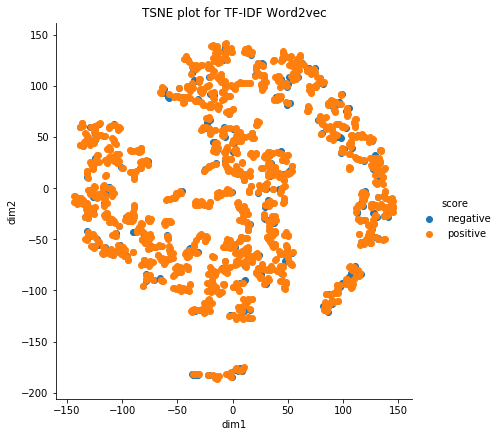

In [59]:
#importing mainfold for visiulization plot from tsne
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 5, n_iter = 5000)

#fitting our model with data
tsne_data = model.fit_transform(tfidf_sent_vectors)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_new)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", height=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE plot for TF-IDF Word2vec")
plt.show()

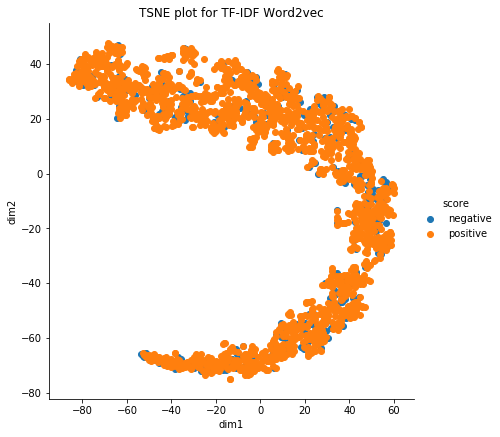

In [60]:
#importing mainfold for visiulization plot from tsne
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 30, n_iter = 5000)

#fitting our model with data
tsne_data = model.fit_transform(tfidf_sent_vectors)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_new)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", height=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE plot for TF-IDF Word2vec")
plt.show()

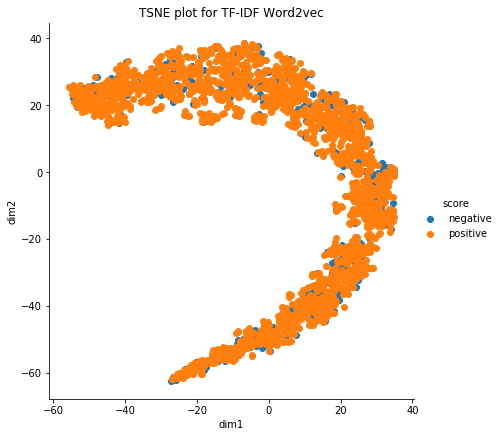

In [61]:
#importing mainfold for visiulization plot from tsne
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 50, n_iter = 5000)

#fitting our model with data
tsne_data = model.fit_transform(tfidf_sent_vectors)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_new)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", height=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE plot for TF-IDF Word2vec")
plt.show()

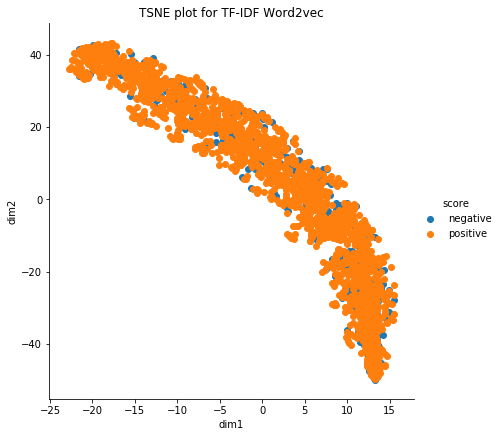

In [62]:
# importing mainfold for visiulization plot from tsne
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 100, n_iter = 5000)

#fitting our model with data
tsne_data = model.fit_transform(tfidf_sent_vectors)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_new)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", height=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE plot for TF-IDF Word2vec")
plt.show()

**Observation-** Positive and negative reviews seems overlapped hence, cant seperate them from each other.

**Conclusions:-**

1. We have plotted 4 different tsne plots but none of them is not useful to seperate +ve and -ve reviews from each other.
2. By looking at tsne visiualization we cant decide to draw a plane or line. 
3. To solve and seperate datapoints like these we need to find other ways.

**Procedure:-**
* 1st step: Performed Exploratory data analysis and data cleaning.
* 2nd step: Performed text preprocessing like Stemming, stop-word removal and Lemmatization.
* 3rd step: Performed data sampling of size 2K reviews for further process.
* 4th step: Calculated bag of words vectoizer for data.
* 5th step: Performed data standardization.
* 6th step: Converted data from sparse to dense.
* 7th step: Plotted t-SNE visiualization of data using different perplexities like 2,5,30,50,100.
* 8th step: Repeated steps from 5 to 7 for TFIDF, Avg W2V, TFIDF W2V vectorizers.
